# Automatic Image-based Medical Report Generation

# Business Approach

* The rapid and successful development of deep learning in research fields such as Computer Vision and Natural Language Processing (NLP) has found an important application area in medical.
 
 
* Research over the last five years shows a clear improvement in computer-aided detection (CAD), specifically in disease prediction from medical images.


* The elaboration of high-quality medical reports from medical images, such as chest X-rays, computed tomography (CT) or magnetic resonance (MRI) scans, is a task that requires a trained radiologist with years of experience.


* We summarize the state of research in automatic report generation from medical images.


* In this task we will perform in X - Ray images and will generate medical report using Deep learining algo


* The lack of specialist physicians is even more critical in resource-limited countries, and therefore the expected impacts of this technology would become even more relevant.


# Deep Learning Approch & Data Overview

* We will different state-of-art method like CNN, LSTM, Attention method for this task, we will generate medical report using X - Rays images.  


* For the this task we will publicly availabel Indian University (IU) datasets. This dataset contain 7471 images, which are images of chest X - Ray (frontal, lateral), report of the corrspoing image in XML file.

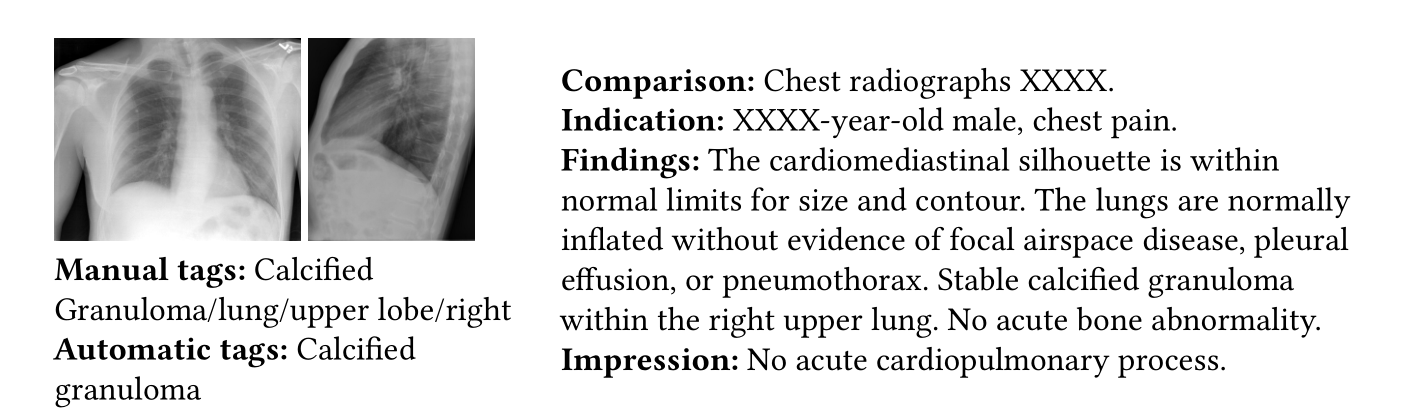

In [584]:
from IPython.display import Image
Image(filename= "Annotation 2021-01-27 230027.png") 

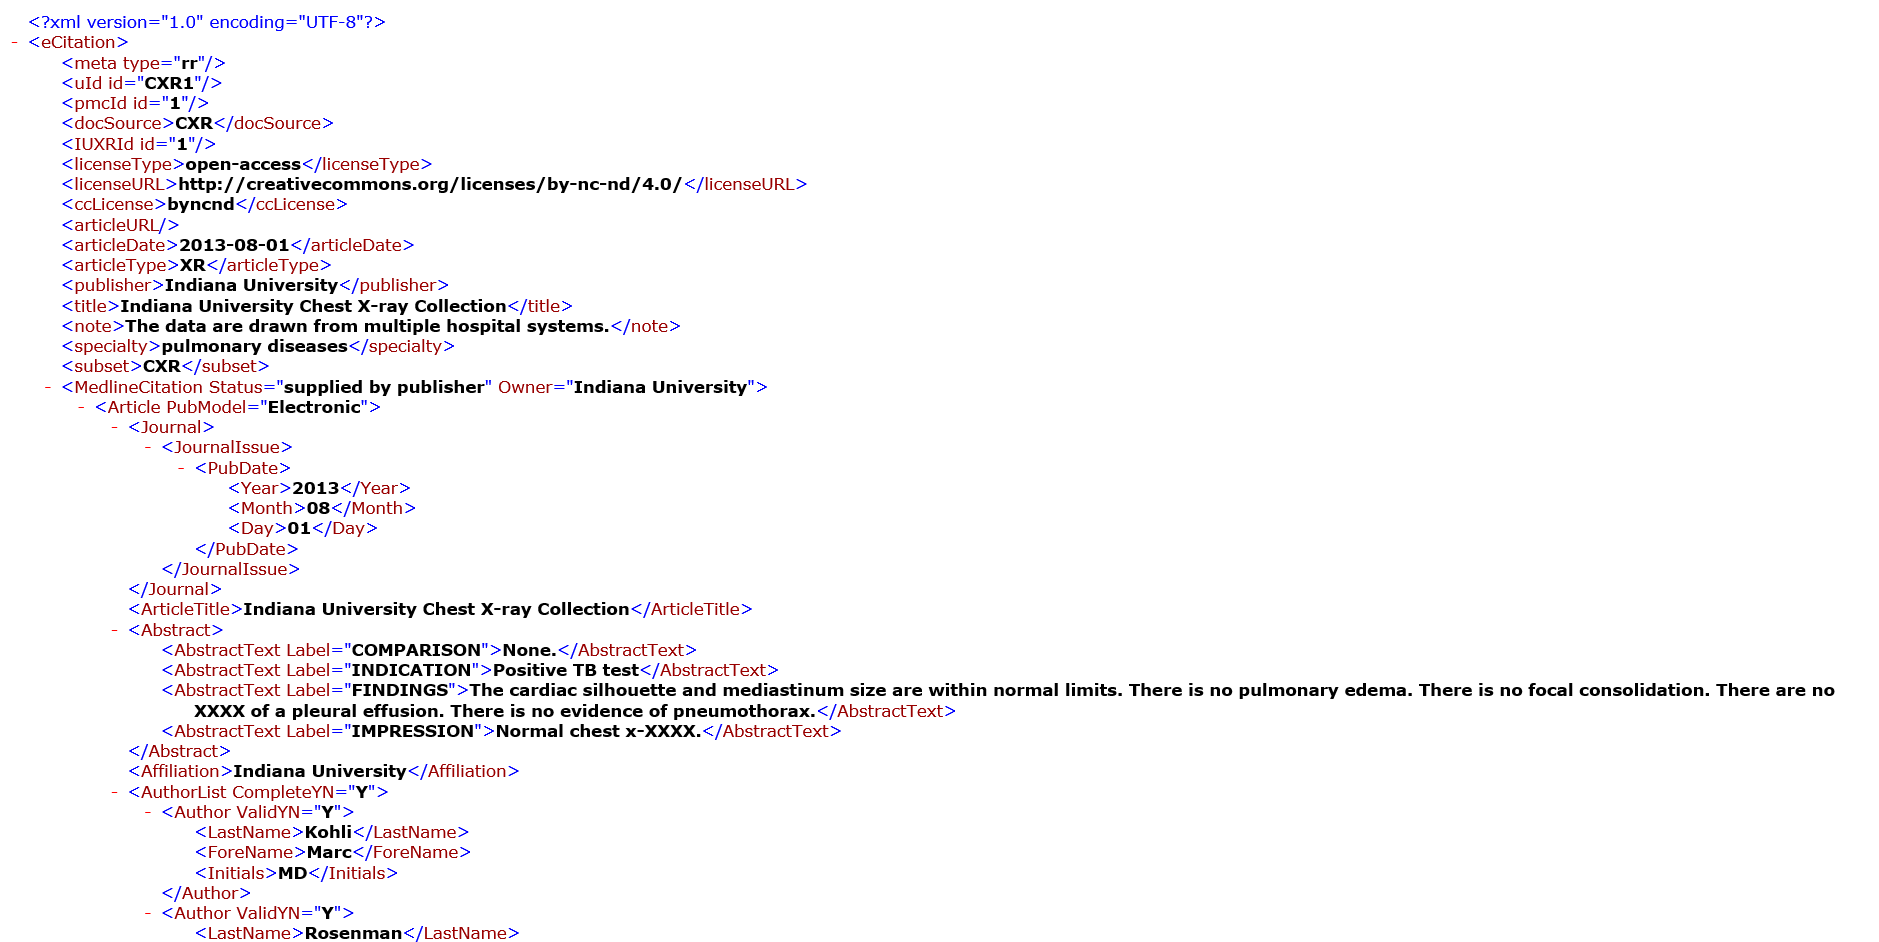

In [585]:
from IPython.display import Image
Image(filename='1.png' ) 

* XML file contain four information for this task. this details as below.

1. Comaprision - information of a serial follow-up procedure

2. Indication  -  information of patient and main problem occurance

3. Findings    -  information in depth about report

4. Impression  - generate by comparision and findings

5. Images - 1. frontal, 2. lateral 

# Import Library

In [23]:
#!pip install lxml
#!pip install opencv-python
#nltk.download('stopwords')
#nltk.download('punkt')

import lxml
import pandas as pd
import numpy as np
from tqdm import tqdm, tqdm_notebook
from bs4 import BeautifulSoup
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize 
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from wordcloud import WordCloud, STOPWORDS
import cv2
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split

os.chdir(r'C:\Users\Dell\Python\Python AAIC File\Assignments\CAST STUDY DL')

# Data Collection

In [7]:
''' Below code refernace from this link '''
#https://stackoverflow.com/questions/2723015/how-to-find-recursively-for-a-tag-of-xml-using-lxml

png = [ ]
indication  = [ ]
comparision = [ ]
findings    = [ ]
impression  = [ ]

os.chdir(r'D:\Assignment DATA\Deep Learning Case Study\data\reports')
dir = os.listdir()

for file in tqdm(dir):
    
    tree = ET.parse(file)
    
    indi = tree.find(".//AbstractText[@Label='INDICATION']").text
    indication.append(indi)
    
    com = tree.find(".//AbstractText[@Label='COMPARISON']").text
    comparision.append(com)
    
    finding = tree.find(".//AbstractText[@Label='FINDINGS']").text
    findings.append(finding)
    
    imp = tree.find(".//AbstractText[@Label='IMPRESSION']").text
    impression.append(imp)
    
    # finall returns a list of matching Elements
    image = set()
    for i in tree.findall('parentImage'):
        img = i.attrib['id']+".png"
        image.add(img)
        
        
    image = ",".join(image)
    png.append(image)
    
os.chdir(r'C:\Users\Dell\Python\Python AAIC File\Assignments\CAST STUDY DL')

100%|█████████████████████████████████████████████████████████████████████████████▉| 3955/3956 [00:55<00:00, 71.07it/s]


ParseError: syntax error: line 1, column 0 (<string>)

In [8]:
df = pd.DataFrame(columns = ['images', 'indication', 'findings', 'impression'])

df['images']      = png
df['indication']  = indication
df['findings']    = findings
df['impression']  = impression

In [9]:
df.head()

,images,indication,findings,impression
0,"CXR1_1_IM-0001-4001.png,CXR1_1_IM-0001-3001.png",Positive TB test,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
1,"CXR10_IM-0002-1001.png,CXR10_IM-0002-2001.png","XXXX-year-old male, chest pain.",The cardiomediastinal silhouette is within nor...,No acute cardiopulmonary process.
2,"CXR100_IM-0002-2001.png,CXR100_IM-0002-1001.png",None,Both lungs are clear and expanded. Heart and m...,No active disease.
3,"CXR1000_IM-0003-2001.png,CXR1000_IM-0003-1001....","XXXX-year-old male, XXXX.",There is XXXX increased opacity within the rig...,1. Increased opacity in the right upper lobe w...
4,"CXR1001_IM-0004-1002.png,CXR1001_IM-0004-1001.png","dyspnea, subjective fevers, arthritis, immigra...",Interstitial markings are diffusely prominent ...,Diffuse fibrosis. No visible focal acute disease.


In [10]:
# Shape of the DataFrame
print('Shape of the Dataframe : ', df.shape)

Shape of the Dataframe :  (3955, 4)


In [11]:
#Check the Null value in Image columns

null = df.isnull().sum()
print("The number of Nan Values in Indication columns -",null[1])
print("The number of Nan Values in findings columns   -",null[2])
print("The number of Nan Values in Impression columns -",null[3])

The number of Nan Values in Indication columns - 90
The number of Nan Values in findings columns   - 530
The number of Nan Values in Impression columns - 34


In [12]:
def zero_len(col):
    '''
    This function take input as dataframe column
    Return count and indicies which values len equal to zero mean Nan
    
    '''
    x = 0
    indices = [ ]
    for i, ix in zip(col.index, col.values) :
        if len(ix) == 0 :
            x += 1 
            indices.append(i)
            
    return x, indices
    

In [13]:
count, ix = zero_len(df['images'])
        
print("The number of Nan Values in Images columns - ", count)
print('Indices of the nan values in the images columns - ', ix[:10])

The number of Nan Values in Images columns -  104
Indices of the nan values in the images columns -  [77, 91, 142, 201, 205, 223, 238, 251, 273, 278]


In [14]:
# Filling the values in-place of nan values

df['indication'] = df['indication'].fillna('No Indication')

df['impression'] = df['impression'].fillna('No Impression')

df['findings']   = df['findings'].fillna('No findings')

In [15]:
df = df.drop(ix)
df.head()

,images,indication,findings,impression
0,"CXR1_1_IM-0001-4001.png,CXR1_1_IM-0001-3001.png",Positive TB test,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
1,"CXR10_IM-0002-1001.png,CXR10_IM-0002-2001.png","XXXX-year-old male, chest pain.",The cardiomediastinal silhouette is within nor...,No acute cardiopulmonary process.
2,"CXR100_IM-0002-2001.png,CXR100_IM-0002-1001.png",No Indication,Both lungs are clear and expanded. Heart and m...,No active disease.
3,"CXR1000_IM-0003-2001.png,CXR1000_IM-0003-1001....","XXXX-year-old male, XXXX.",There is XXXX increased opacity within the rig...,1. Increased opacity in the right upper lobe w...
4,"CXR1001_IM-0004-1002.png,CXR1001_IM-0004-1001.png","dyspnea, subjective fevers, arthritis, immigra...",Interstitial markings are diffusely prominent ...,Diffuse fibrosis. No visible focal acute disease.


In [16]:
# Shape of the DataFrame
print('Shape of the Dataframe : ', df.shape)

Shape of the Dataframe :  (3851, 4)


In [17]:
null = df.isnull().sum()
print("The number of Nan Values in Indication columns -",null[1])
print("The number of Nan Values in findings columns   -",null[2])
print("The number of Nan Values in Impression columns -",null[3])

The number of Nan Values in Indication columns - 0
The number of Nan Values in findings columns   - 0
The number of Nan Values in Impression columns - 0


In [18]:
count, ix = zero_len(df['images'])
print("The number of Nan Values in Images columns - ", count)
print('Indices of the nan values in the images columns - ', ix[:10])

The number of Nan Values in Images columns -  0
Indices of the nan values in the images columns -  []


In [14]:
df.to_csv('df.csv')

# Observation : 

*  As per our observation we say that dataset have 3955 rows and 4 columns, columns are indication, impression, comparision and images of x - rays extract from XML files.


* We see that indication feature have 93 None value, impression feature have 34 None value and findings feature have 530 None value. As per observation see that total 104 None values in images features.


* So we removed total 104 rows in our datatsets. And replace value text in place of Nan values in other features.

# Data Preprocess

In [19]:
def decontracted(phrase):
    
    ''' 
    This function take input as string 
    return string with decontracted
    '''
    # specific
    phrase = phrase.lower()
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

########################################################

def text_preprocess(text):
    
    ''' 
    this function take input as string
    return preprocess without special chr, lowecase, string
    '''
    
    text = text.lower()
    text = re.sub("xxxx", "", text)
    text = re.sub("xxx", "", text)
    text = re.sub("-", "_", text)
    text = re.sub('&', ' and ',text)
    text = re.sub('@', ' at ',text)
    text = re.sub('0', ' zero ',text)
    text = re.sub('1', ' one ',text)
    text = re.sub('2', ' two ',text)
    text = re.sub('3', ' three ',text)
    text = re.sub('4', ' four ',text)
    text = re.sub('5', ' five ',text)
    text = re.sub('6', ' six ',text)
    text = re.sub('7', ' seven ',text)
    text = re.sub('8', ' eight ',text)
    text = re.sub('9', ' nine ',text)
    text = re.sub(r"[|\'||\\||/|?|$|.|.|,||;|><!&)(:`\n\t@#=+%^*~-]","",text)
    text = re.sub(r'\.\.+', '.',text)
    text = re.sub(r"\d", "", text)
    text = re.sub('year old', "", text)     
    text = re.sub('yearold', "", text)
    text = re.sub('[^a-z]+', ' ', text)
    
    
    return text

#######################################################

def remove_stop_words(text):
    
    ''' 
    Input = text
    return = text
    This remove stop words form text
    '''
    
    stop_words = (stopwords.words('english'))  
    stop_words.remove('not')                           
    stop_words.remove('no')
    word_tokens = word_tokenize(text)  
    
    filtered_sentence = []  
    for w in word_tokens:  
        if w not in stop_words:  
            filtered_sentence.append(w)  
        
    return " ".join(filtered_sentence) 

####################################################

def less_two_remove(text):
    
    '''
    input = string
    return = string
    this function take input and remove string which len is less than 2
    '''
    
    word_list = word_tokenize(text)
    
    need = ['tb', 'no', 'mm', 'ct']
    
    text = [ ]
    for i in word_list :
        if len(i) <= 2 :
            if i in need :
                #print(i)
                text.append(i)
        else:
            #print(i)
            text.append(i)

    return " ".join(text)

###################################################
    
def final_preprocess(text):
    
    '''
    This function combine all other def funcation
    '''
    
    text = decontracted(text)
    text = text_preprocess(text)
    text = remove_stop_words(text)
    text = less_two_remove(text)
    
    return text

In [20]:
# map the function in pandas cols
df['indication'] = df['indication'].map(final_preprocess)
df['impression'] = df['impression'].map(final_preprocess)
df['findings']   = df['findings'].map(final_preprocess)

In [21]:
df.indication

0                                        positive tb test
1                                year old male chest pain
2                                           no indication
3                                           year old male
4       dyspnea subjective fevers arthritis immigrant ...
                              ...                        
3950                                    cabg sob no rales
3951                                           chest pain
3952                    year old female transplant workup
3953                                        year old pain
3954                                           chest pain
Name: indication, Length: 3851, dtype: object

In [235]:
#check the nan value in the indicaiton featues

count, ix = zero_len(df['indication'])
print("The number of Nan Values in Images columns - ", count)
print('Indices of the nan values in the images columns - ', ix[:10])

The number of Nan Values in Images columns -  229
Indices of the nan values in the images columns -  [14, 22, 44, 49, 86, 100, 102, 129, 136, 147]


In [236]:
# replace the nan value to the no indication value
for i in ix :
    df['indication'][i] = 'no indication'

In [237]:
#check the nan value in the indicaiton features

count, ix = zero_len(df['indication'])
print("The number of Nan Values in Images columns - ", count)
print('Indices of the nan values in the images columns - ', ix[:10])

The number of Nan Values in Images columns -  0
Indices of the nan values in the images columns -  []


In [238]:
#check the nan value in the impression features

count, ix = zero_len(df['impression'])
print("The number of Nan Values in Images columns - ", count)
print('Indices of the nan values in the images columns - ', ix[:10])

The number of Nan Values in Images columns -  0
Indices of the nan values in the images columns -  []


In [239]:
#check the nan value in the findings features

count, ix = zero_len(df['findings'])
print("The number of Nan Values in Images columns - ", count)
print('Indices of the nan values in the images columns - ', ix[:10])

The number of Nan Values in Images columns -  0
Indices of the nan values in the images columns -  []


In [26]:
d = pd.read_csv("final_df.csv")
d.iloc[:, 1:]

,image_1,image_2,impression
0,CXR1_1_IM-0001-3001.png,CXR1_1_IM-0001-4001.png,normal chest
1,CXR10_IM-0002-2001.png,CXR10_IM-0002-1001.png,no acute cardiopulmonary process
2,CXR100_IM-0002-2001.png,CXR100_IM-0002-1001.png,no active disease
3,CXR1000_IM-0003-1001.png,CXR1000_IM-0003-2001.png,increased opacity right upper lobe associated ...
4,CXR1001_IM-0004-1002.png,CXR1001_IM-0004-1001.png,diffuse fibrosis no visible focal acute disease
...,...,...,...
3846,CXR995_IM-2478-1001.png,CXR995_IM-2478-1002.png,post operative chest no acute disease
3847,CXR996_IM-2479-1001.png,CXR996_IM-2479-2001.png,heart size normal lungs clear no pneumothorax ...
3848,CXR997_IM-2479-2001.png,CXR997_IM-2479-1001.png,no acute cardiopulmonary abnormality
3849,CXR998_IM-2479-2001.png,CXR998_IM-2479-1001.png,no acute cardiopulmonary abnormality


# Observation :

* We did some text preprocess in XML three labels (indcation, impression, findings) we anallize the text data then we did preprocess like decontraction (can't ---> can not), remove special character, convert in lowercase and remove stop words.


* After analize preprocess text data we observe some words frequently present in text like "year old, yearold" we removed those type of words and remove words which length are less than 2.


* And also removed words which length are two, except words like tb, mm, no.


* After preprocess the data, we got 229 nan values in indcation feature, we replace nan value to "no indication". 

# Explorary Data Analysis

## 1. Analysis Of Indication Feature

### Unique words in Feature

In [240]:
def unique_words_features(data):
    ''' 
    Input  =  pandas dataframe or numpy arrays
    Output =  barplot of the unique words of dataframe 
    This function take pandas dataframe and show barplot of features unique and repeated words 
    '''

    # Len of the indication feature
    len_findings = len(data.tolist())

    # Len of the unique words in indication featue
    unique_findings = len(np.unique(data.tolist()))

    x = ['Repeated Values', 'Unique Values']
    y =  [len_findings, unique_findings]

    # Plot size
    plt.figure(figsize= (10,8))

    plt.barh(x,y)

    #https://www.kite.com/python/answers/how-to-display-the-value-of-each-bar-in-a-bar-chart-using-matplotlib-in-python
    for index, value in enumerate(y):
        plt.text(value, index, str(value))
    
    plt.ylabel('Counts')
    plt.title('Unique Words in Feature')
    plt.show()

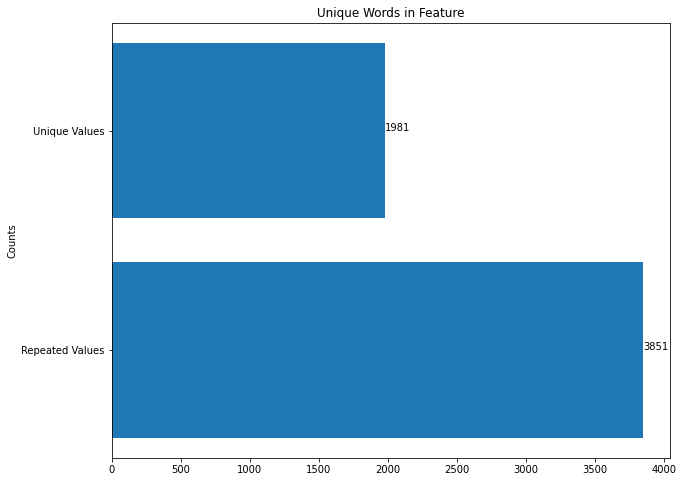

In [241]:
unique_words_features(df.indication)

# Observation :

# How many Unique words and Repeated words in feature ?

* We conclude from above indication features bar plot, total 3851 approx words are repated in indication feature and total 1981 words are unique in feature.


* Repeated words like 'no indication', 'abnormality', 'cardiovarcular', etc. and unique words like 'acute sinusitis', 'altered mental status falling' types of words.

### Words legnth in Feature

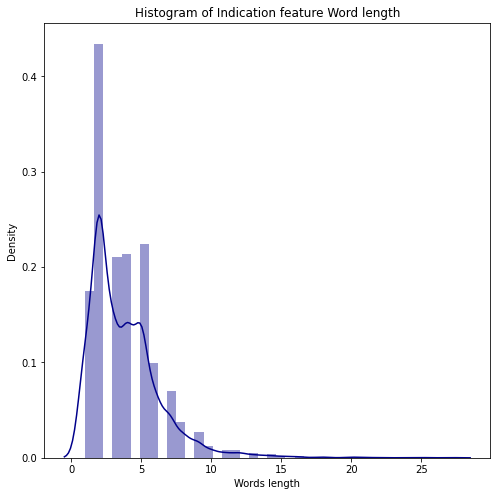

In [242]:
length_indication = df.indication.str.split().str.len()

# plot size
plt.figure(figsize = (8, 8))
      
# seaborn histogram
sns.distplot(length_indication, hist=True, kde=True,bins= 40,
             color = 'Darkblue')

# Add label and title
plt.title('Histogram of Indication feature Word length')
plt.xlabel('Words length')
plt.show()

# Observation :

# How many percentage of data have hight and lower legnth ?

* We observe from above plot, more than 40% of words length are lies between 2-5, 5% words length lies between 5-10.

* Only few words length lies between above  12.

## Count Frequent Words in Feature 

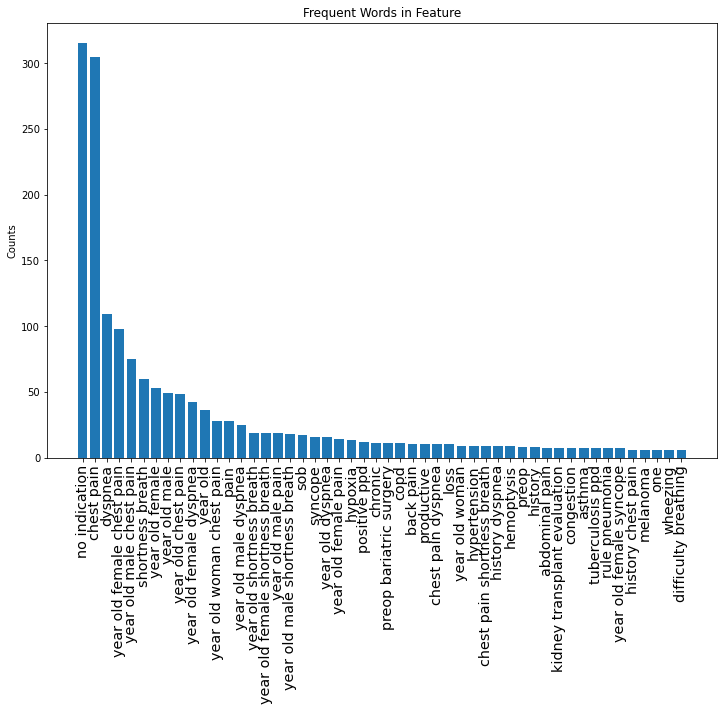

In [243]:
counts = df.indication.value_counts()[:50]

# Plot size
plt.figure(figsize= (12,8))

plt.bar(counts.index, counts.values)
plt.ylabel('Counts')
plt.title('Frequent Words in Feature')
plt.xticks(rotation=90, fontsize='x-large')
plt.show()

# Observation :

# which words are more frequent in feature ?


 * We observe from above plot, plot indicates top 50 frequent words in indication feature. top two most frequent words are 'no indication' and 'chest pain' above 300 counts in feature.
 
 * we observe majority text is chest pain and no indication or patient deatil in indication medical report. 

### CDF of Words length indication feature

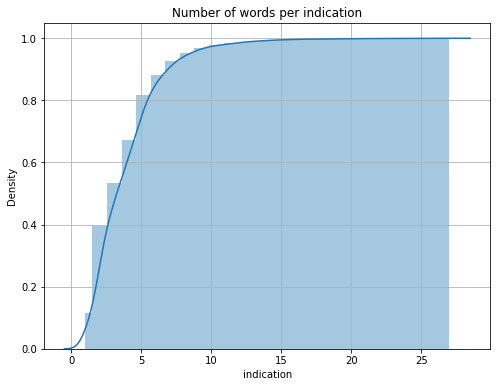

In [244]:
# Change the size of the plot
plt.figure(figsize = (8, 6))

# Seaborn CDF
sns.distplot(length_indication, hist_kws={'cumulative': True, 'density': True}, kde_kws={'cumulative': True})

# Add labels and its range
plt.title('Number of words per indication')
plt.grid()
plt.show()

# Observation :

# What is the 50th, 99th percentile of word length in indication feature ?

* We conclude from above plot, in indication feature 50% data have 7-8 words, 99% text data have less than 10 words in rows. Only 1% data have bove legnth 10.

In [245]:
#https://stackoverflow.com/questions/16645799/how-to-create-a-word-cloud-from-a-corpus-in-python

stopwords = (stopwords.words('english')) 
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=1000,
        max_font_size=110, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(18,18))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

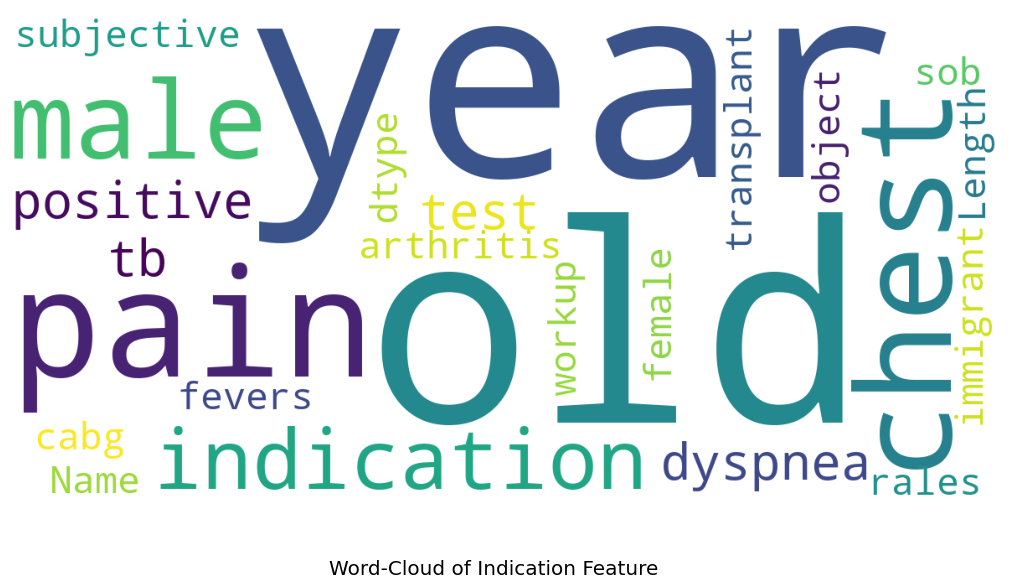

In [246]:
show_wordcloud(df['indication'], title = 'Word-Cloud of Indication Feature')

# Observation :

* Above word cloud are generated on the top 1000 max occurrence words.  

* Year, old, chest, male, indication, tb, positive, female, these are the highlighted words from above visualization, these are important words.

## 2. Analysis of Impression Feature

### Unique words in Feature

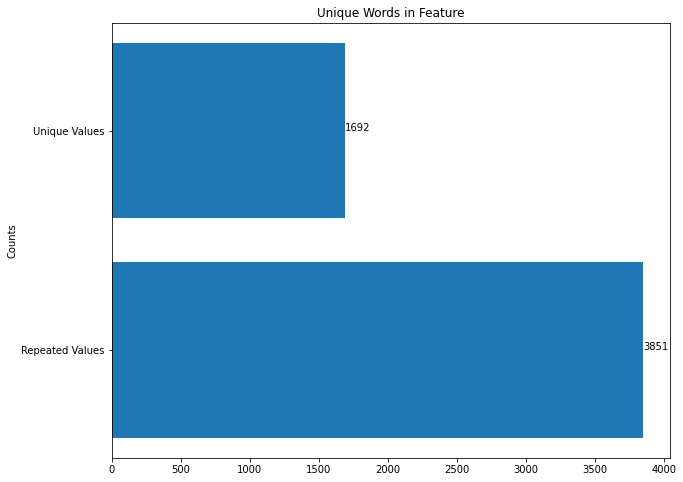

In [247]:
unique_words_features(df.impression)

# Observation :

# How many Unique words and Repeated words in feature ? 

* We conclude from above impression features bar plot, total 3851 approx words are repated in impression feature and total 1692 words are unique in feature.


### Word counts of Feature

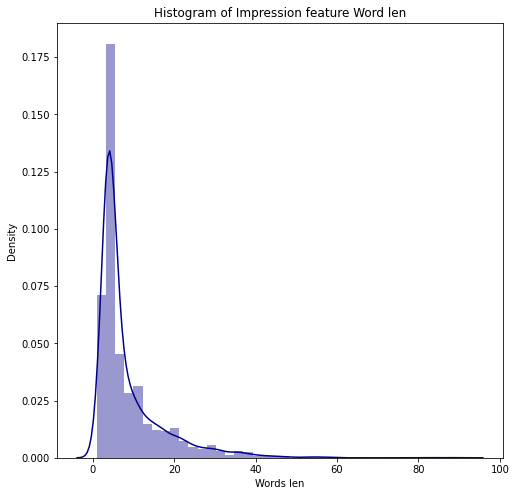

In [248]:
length_impression = df.impression.str.split().str.len()

# plot size
plt.figure(figsize = (8, 8))
      
# seaborn histogram
sns.distplot(length_impression, hist=True, kde=True,bins= 40,
             color = 'Darkblue')

# Add label and title
plt.title('Histogram of Impression feature Word len')
plt.xlabel('Words len')
plt.show()

# Observation :

## How many percentage of data have hight and lower legnth ?

* We conclude from above plot, 50% text data length lie between 2-15 and 90% of the data length lies between 2-20.

* 2-10 words length more occurance in impression feature.

* Impression feature text data length more than indication feature, higher and lower value of length in impression feature are 90 words, 2 words respectivaly.

# Count Frequent Words in Feature

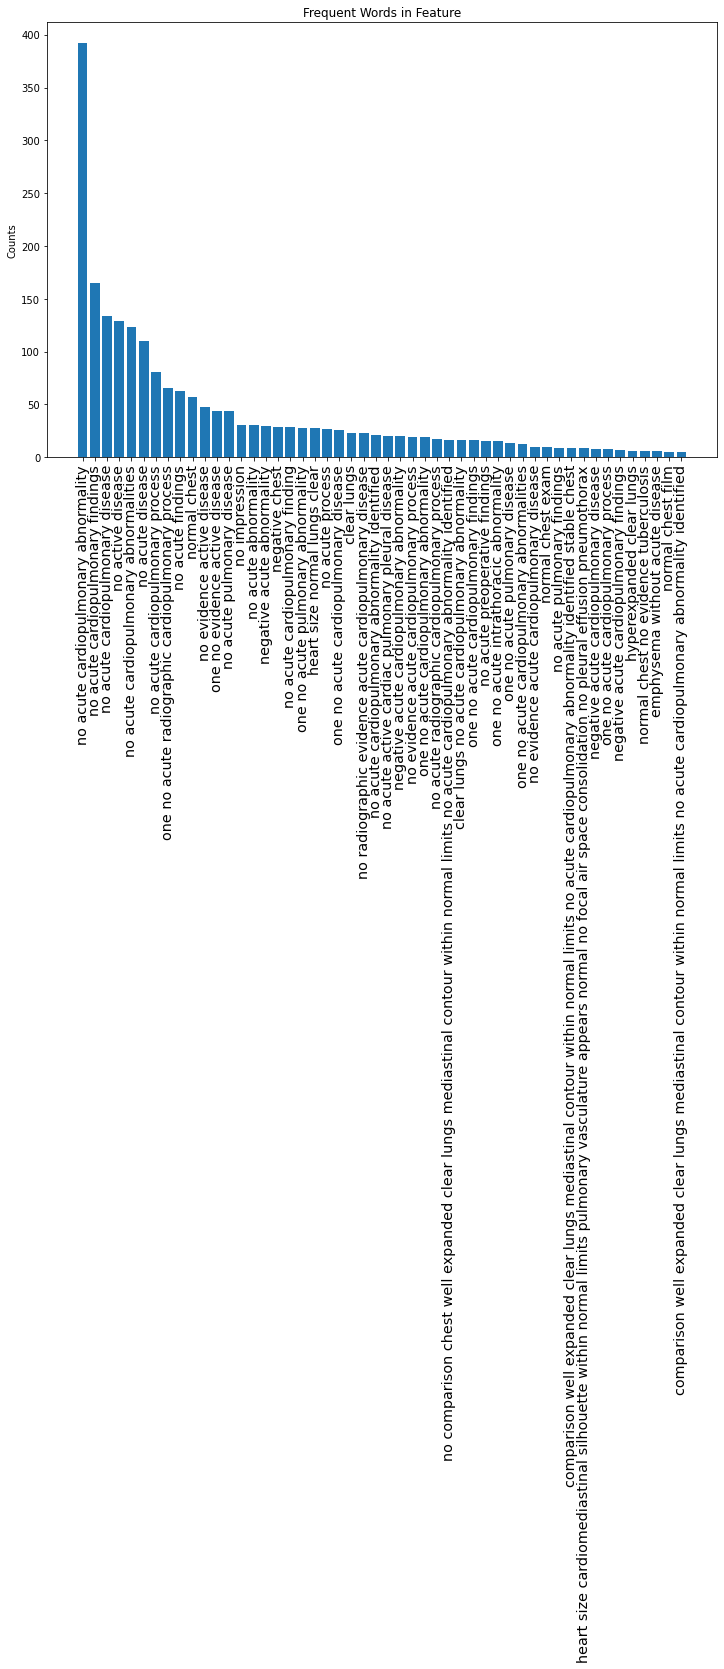

In [249]:
# get the most frequent words in dataframe
counts = df.impression.value_counts()[:50]

# Plot size
plt.figure(figsize= (12,8))

plt.bar(counts.index, counts.values)
plt.ylabel('Counts')
plt.title('Frequent Words in Feature')
plt.xticks(rotation=90, fontsize='x-large')
plt.show()

# Observation :

## which words are more frequent in feature ?
 

 * We observe from above plot, plot indicates top 50 frequent words in impression feature. top two most frequent words are 'no actue cardiopulmonary abnormality' and 'no actue cardiopulmonary findings' above 400 counts in feature.
 
 
 * we observe majority text are 'no actue cardiopulmonary abnormality' and 'no actue cardiopulmonary findings' it means high number patient have no any abnormality, no any diseas.

### CDF of Words length impression feature

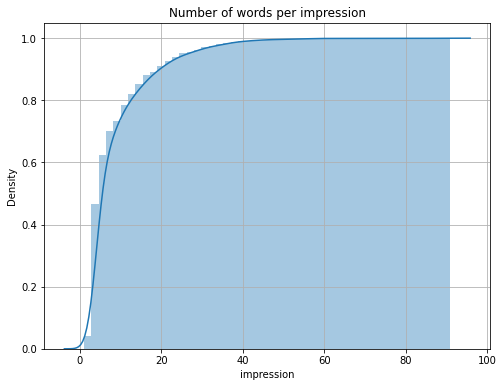

In [250]:
# Change the size of the plot
plt.figure(figsize = (8, 6))

# Seaborn CDF
sns.distplot(length_impression, hist_kws={'cumulative': True, 'density': True}, kde_kws={'cumulative': True})

# Add labels and its range
plt.title('Number of words per impression')
plt.grid()
plt.show()

# Observation : 

## What is the 50th, 99th percentile of word length in indication feature ?

* We conclude from above plot, We see that higher number words in impression. 

* 50% data have less than 4 words per impression, it means only few impression have less words.

* 99% data have less than 39 words per impression.

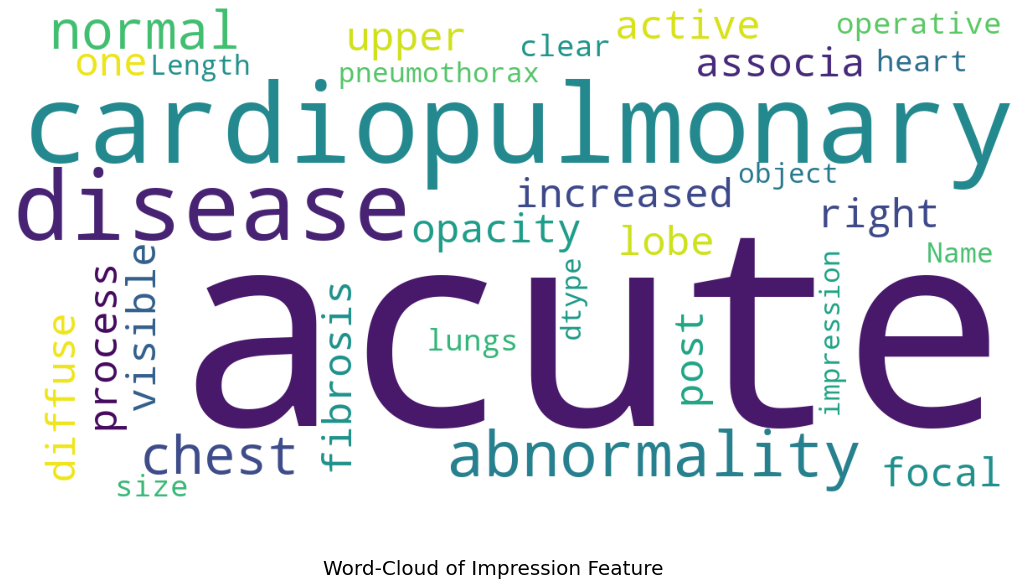

In [251]:
show_wordcloud(df['impression'], title = 'Word-Cloud of Impression Feature')

# Observation :

* Above word cloud are generated on the top 1000 max occurrence words.  

* Acute, disease, abnormality, cardiopulmonary, normal, visible these are the highlighted words from above visualization, these are important words.

# 3. Analysis of Findings Feature

### Unique words in Feature 

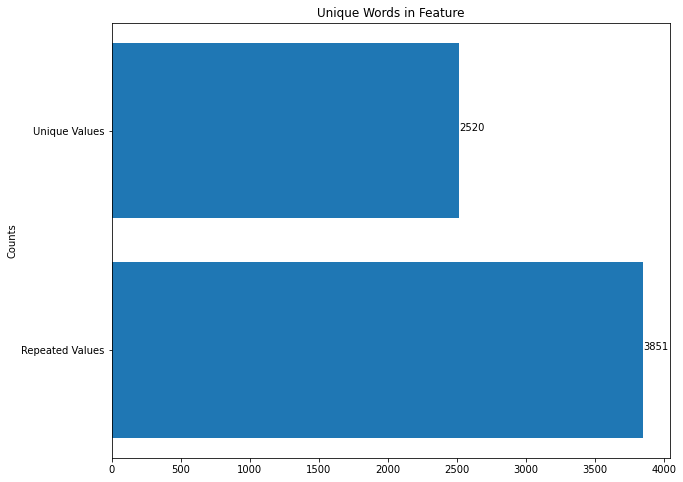

In [252]:
unique_words_features(df.findings)

# Observation :

## How many Unique words and Repeated words in feature ? 

* We conclude from above findings features bar plot, total 3851 approx words are repated in findings feature and total 2520 words are unique in feature.


### Word counts of Feature 

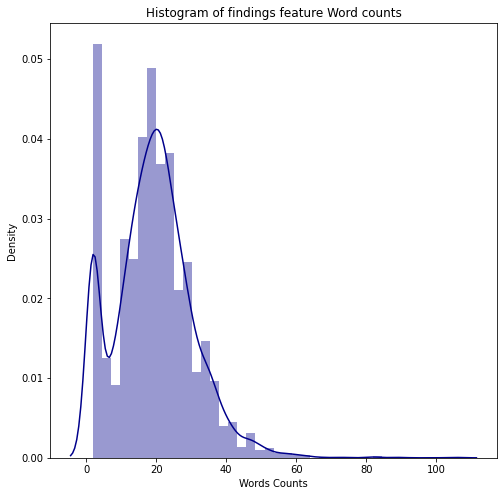

In [253]:
# get the len of the sentence per row
length_findings = df.findings.str.split().str.len()

# plot size
plt.figure(figsize = (8, 8))
      
# seaborn histogram
sns.distplot(length_findings, hist=True, kde=True,bins= 40,
             
             color = 'Darkblue')

# Add label and title
plt.title('Histogram of findings feature Word counts')
plt.xlabel('Words Counts')
plt.show()

# Observation :

## How many percentage of data have hight and lower legnth ?

* 90% data length lies between 5-40 words per findings. some content higher dense in 2-10 words, 10-30 words length content density cross 0.025, some few words cross 80 words per findings. 

### CDF of Findings feature

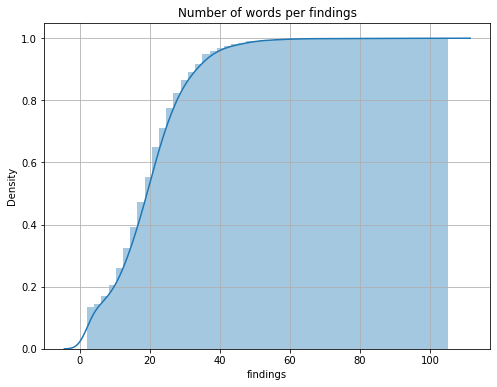

In [254]:
# Change the size of the plot
plt.figure(figsize = (8, 6))

# Seaborn CDF
sns.distplot(length_findings, hist_kws={'cumulative': True, 'density': True}, kde_kws={'cumulative': True})

# Add labels and its range
plt.title('Number of words per findings')
plt.grid()
plt.show()

# Observation : 

## What is the 50th, 99th percentile of word length in indication feature ?

* We conclude from above plot, We see that some fingdings cross 80 words per findings. 

* 50% data have less than 20 words per findings, 99% data have less than 48 words per findings.

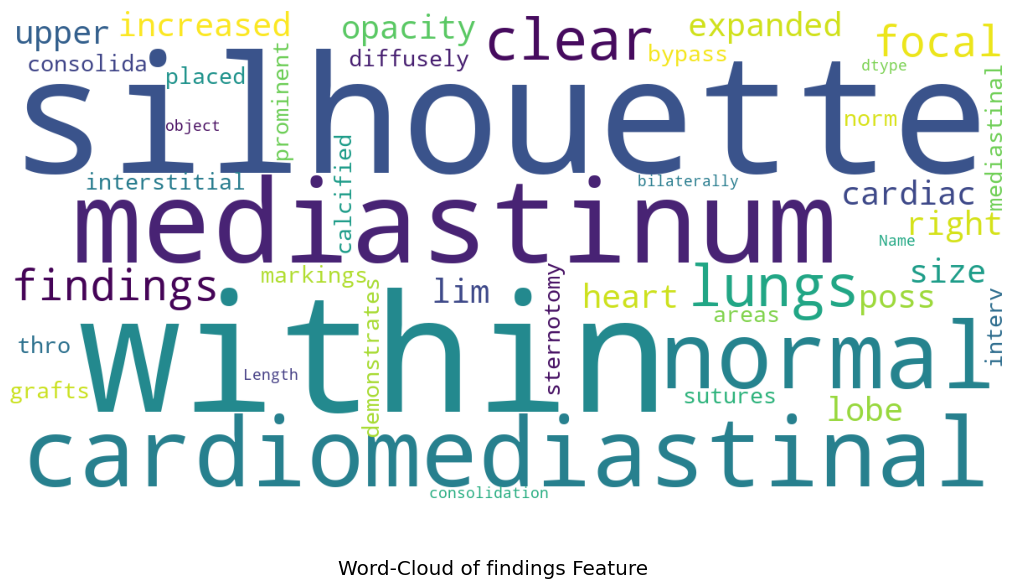

In [255]:
show_wordcloud(df['findings'], title = 'Word-Cloud of findings Feature')

# Observation :

* Above word cloud are generated on the top 1000 max occurrence words.  
* Silhouette, mediastinum, within, normal, lungs, cardiomediastinal are the highlighted words from above visualization, these are important words.

# 4. Analysis of Images Feature

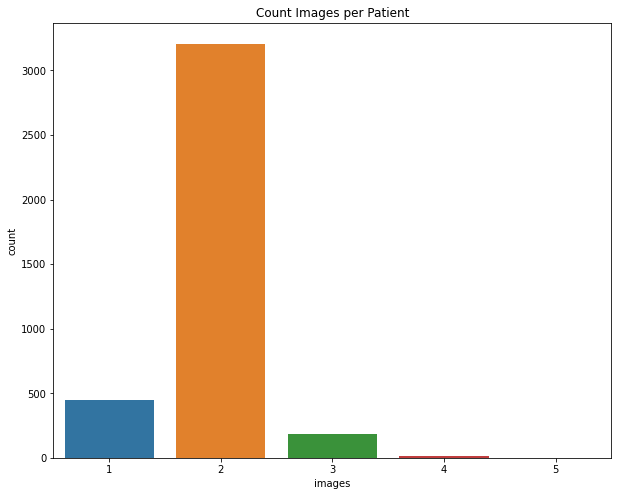

In [256]:
# count the images per patients
image_count = df.images.str.split(',').str.len()

# Plot size
plt.figure(figsize= (10,8))
sns.countplot(image_count)
plt.title('Count Images per Patient')
plt.show()

In [257]:
print('Image Count : ')
print(image_count.value_counts())

Image Count : 
2    3208
1     446
3     181
4      15
5       1
Name: images, dtype: int64


# Observation :

* We can see that above count plot of patient, higher number patients have two chest x - ray images, than one image and than 3 image. Only few patient have 4-5 images of x - ray.


* As per observation we will choose two image per patient, when patient have more than two images we will choose only two and other remove it, if patient have one image of x - ray then we will duplicate first one.


* Total 3208 rows have two images, and lowest value of row is 5 images, so we will convert all more than 2 images two images.  

# 5. Raw Data-Overview

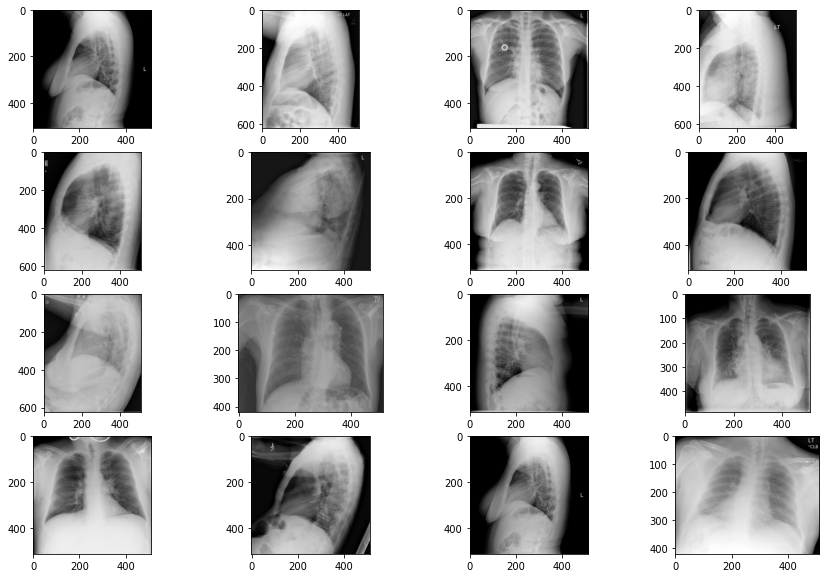

In [258]:
# set the path of image
path = 'D:\Assignment DATA\Deep Learning Case Study\png'
os.chdir(path)

# 10 random image index
ix = np.random.randint(low=1, high=100, size=16) 
image = os.listdir()

fig, ax = plt.subplots(4,4, figsize = (15,10))
axs = ax.flatten()              
for i,x in zip(axs, ix) :
    img = mpimg.imread(image[x])
    i.imshow(img) 

plt.show()
os.chdir(r'C:\Users\Dell\Python\Python AAIC File\Assignments\CAST STUDY DL')

In [259]:
# Image Data
print('Image data :')
df.images.values.tolist()[1030:1050]

Image data :


['CXR196_IM-0626-1001.png',
 'CXR1960_IM-0627-1003002.png,CXR1960_IM-0627-1002001.png',
 'CXR1961_IM-0628-2001.png,CXR1961_IM-0628-3001.png',
 'CXR1962_IM-0628-3003.png,CXR1962_IM-0628-2002.png',
 'CXR1963_IM-0629-1001.png,CXR1963_IM-0629-2001.png',
 'CXR1964_IM-0629-1001.png,CXR1964_IM-0629-2001.png',
 'CXR1965_IM-0629-2001.png,CXR1965_IM-0629-1001.png',
 'CXR1966_IM-0629-1001.png,CXR1966_IM-0629-1002.png',
 'CXR1967_IM-0629-3001.png,CXR1967_IM-0629-1001.png',
 'CXR1968_IM-0630-2001.png,CXR1968_IM-0630-4004.png',
 'CXR1969_IM-0630-1001.png',
 'CXR197_IM-0631-1001.png,CXR197_IM-0631-1002.png',
 'CXR1970_IM-0632-1001.png,CXR1970_IM-0632-2001.png',
 'CXR1971_IM-0633-1001.png,CXR1971_IM-0633-2001.png',
 'CXR1972_IM-0633-1002.png,CXR1972_IM-0633-1001.png',
 'CXR1973_IM-0633-1002.png,CXR1973_IM-0633-1001.png',
 'CXR1974_IM-0633-2001.png,CXR1974_IM-0633-1001.png',
 'CXR1975_IM-0634-1001.png,CXR1975_IM-0634-2001.png,CXR1975_IM-0634-3001.png',
 'CXR1976_IM-0635-1001-0002.png,CXR1976_IM-0635-10

# Observation : 

* We conclude from above information some rows have two images and some have three images. 

* Total 446 rows have only one image of chest frontal or latral part.


# Image Data Preprocess

In [260]:
# below dataset taken from kaggle 
os.chdir(r'C:\Users\Dell\Python\Python AAIC File\Assignments\CAST STUDY DL')
project = pd.read_csv('indiana_projections.csv')

project

,uid,filename,projection
0,1,1_IM-0001-4001.dcm.png,Frontal
1,1,1_IM-0001-3001.dcm.png,Lateral
2,2,2_IM-0652-1001.dcm.png,Frontal
3,2,2_IM-0652-2001.dcm.png,Lateral
4,3,3_IM-1384-1001.dcm.png,Frontal
...,...,...,...
7461,3997,3997_IM-2048-1002.dcm.png,Lateral
7462,3998,3998_IM-2048-1001.dcm.png,Frontal
7463,3998,3998_IM-2048-1002.dcm.png,Lateral
7464,3999,3999_IM-2049-1001.dcm.png,Frontal


In [261]:
image_1, image_2, impression = [], [], []

for ix,content in tqdm(df.iloc[:, :].iterrows()):
    
    # split the data by comma
    image = content['images'].split(',')
    imp = content['impression']
    
    # if 1 images in row
    if len(image) == 1 :
        image_1.append(image[0])
        image_2.append(image[0])
        impression.append(imp)
        
    # if 2 images in row
    elif len(image) == 2 :
        image_1.append(image[0])
        image_2.append(image[1])
        impression.append(imp)
        
        
    # if 3 images in row        
    elif len(image) == 3 :
        frontal = dict()
        lateral = dict()
        for ix,i in enumerate(image) :
            label = project[project['filename'].str.contains(re.search(r"\d.*\_IM-\d.*\.", i).group())]['projection'].values
            label = "".join(label)
            
            if label == 'Frontal' :
                frontal[ix] = (label)
            elif label == 'Lateral':
                lateral[ix] = (label)
        
        for i in range(2):
            if len(frontal) == 2 :
                image_1.append(image[i])
                image_2.append(image[-1])
                impression.append(imp)
                
            else :
                image_1.append(image[i * 2])
                image_2.append(image[1])
                impression.append(imp)
    
    # if 4 images in row
    elif len(image) == 4 :
        frontal = dict()
        lateral = dict()
        for ix,i in enumerate(image) :
            label = project[project['filename'].str.contains(re.search(r"\d.*\_IM-\d.*\.", i).group())]['projection'].values
            label = "".join(label)
            
            if label == 'Frontal' :
                frontal[i] = (label)
            elif label == 'Lateral':
                lateral[i] = (label)
            
        for i in range(2):
            image_1.append(image[i*1])
            image_2.append(image[3-i])
            impression.append(imp)
                
    # if data point contain 5 images
    elif len(image) == 5 :
        frontal = dict()
        lateral = dict()
        for i in image :
            label = project[project['filename'].str.contains(re.search(r"\d.*\_IM-\d.*\.", i).group())]['projection'].values
            label = "".join(label)
            
            if label == 'Frontal' :
                frontal[i] = (label)
            elif label == 'Lateral':
                lateral[i] = (label)
        
        for i in range(4):
            image_1.append(image[i])
            image_2.append(image[-1])
            impression.append(imp)
            

3851it [00:05, 750.19it/s] 


In [262]:
# check the list len
len(image_1), len(image_2), len(impression)

(4050, 4050, 4050)

# Observation :


* We create final dataframe for the our model, dataset contains three image_1 and image_2 contain x ray image. We converted multipal images into two images. We proceed as follow

1. if data point contain single image, we replicate image and convert into two images.

* 1_frontal ---> 1_frontal, 1_frontal

2. if data point contains two images we separated frontal and lateral lists.

* 1_frontal, 1_lateral --- > 1_frontal, 1_lateral

3. if data point contains three images.

* 1_frontal, 1_lateral, 2_lateral  --- >
* 1_frontal, 1_lateral 
* 1_frontal, 2_lateral  

4. if data point contains four images.

* 1_frontal, 1_lateral, 2_frontal, 2_lateral  --- >

* 1_frontal, 1_lateral 
* 2_frontal, 2_lateral  

5. if data point contains five images.

* 1_frontal, 2_frontal, 3_frontal, 4_frontal, 1_lateral  --- >

* 1_frontal, 1_lateral 
* 2_frontal, 1_lateral  
* 3_frontal, 1_lateral 
* 4_frontal, 1_lateral  


In [263]:
list_1 = [ ]

for x,y,imp in tqdm(zip(image_1, image_2,impression)):
    
    # check the image projection of the different images
    # return frontal or lateral of the given image
    front = project[project['filename'].str.contains(re.search(r"\d.*\_IM-\d.*\.", x).group())]['projection'].values
    later = project[project['filename'].str.contains(re.search(r"\d.*\_IM-\d.*\.", y).group())]['projection'].values
    
    front = "".join(front)
    later = "".join(later)
    
    if (front == 'Lateral') and (later == 'Frontal'):
        list_1.append((y,x,imp))
    else:
        list_1.append((x,y, imp))


4050it [00:57, 70.68it/s]


# Observation :

* As per observation we found some rows have not in frontal and lateral order, so we used projection datasets, projection dataset contains chest x ray images and its projections like image frontal or lateral part.


* Using projection of images, we separated frontal and lateral images and stored in the lists. 

In [264]:
# store values in the the lists
frontal, lateral, impression = [] ,[] ,[]
for i in list_1 :
    frontal.append(i[0])
    lateral.append(i[1])
    impression.append(i[2])

In [265]:
# create the dataframe
last = pd.DataFrame(columns = ['frontal', 'lateral', 'impression'])
last['frontal'] = frontal
last['lateral'] = lateral
last['impression'] = impression

In [266]:
# save the dataframe
last.to_csv('last3.csv')

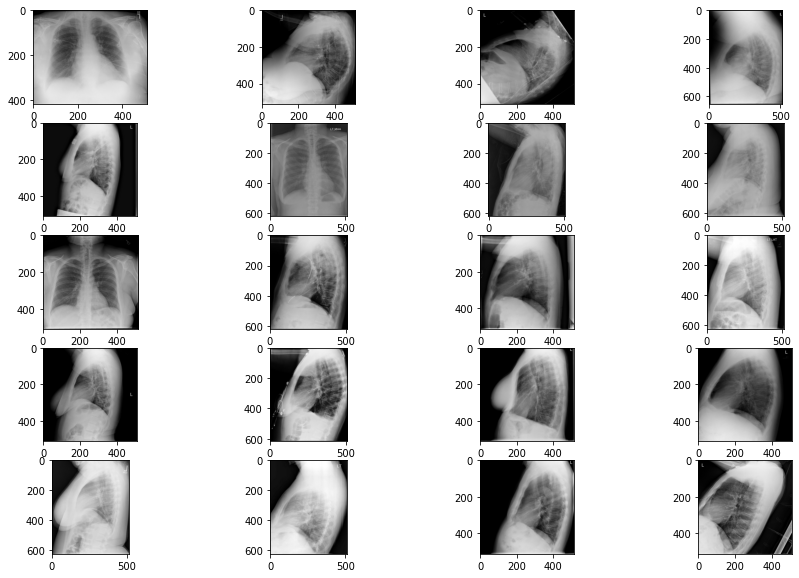

In [267]:
# set the path of image
path = 'D:\Assignment DATA\Deep Learning Case Study\png'
os.chdir(path)

# frontal and lateral images 
image = last.frontal.tolist()[40:60]
image1 = last.lateral.tolist()[40:60]

fig, ax = plt.subplots(5,4, figsize = (15,10))
axs = ax.flatten()
     
for i in range(20):
    img = mpimg.imread(image[i])
    img1 = mpimg.imread(image1[i])
    axs[i].imshow(img) 
    axs[i].imshow(img1)

plt.show()
os.chdir(r'C:\Users\Dell\Python\Python AAIC File\Assignments\CAST STUDY DL')

# Data Splitting

In [27]:
final_df = pd.read_csv('last3.csv')
final_df = final_df.iloc[:,1:]

In [29]:
final_df

,frontal,lateral,impression
0,CXR1_1_IM-0001-3001.png,CXR1_1_IM-0001-4001.png,normal chest
1,CXR10_IM-0002-2001.png,CXR10_IM-0002-1001.png,no acute cardiopulmonary process
2,CXR100_IM-0002-1001.png,CXR100_IM-0002-2001.png,no active disease
3,CXR1000_IM-0003-3001.png,CXR1000_IM-0003-1001.png,one increased opacity right upper lobe associa...
4,CXR1000_IM-0003-1001.png,CXR1000_IM-0003-2001.png,one increased opacity right upper lobe associa...
...,...,...,...
4045,CXR996_IM-2479-1001.png,CXR996_IM-2479-2001.png,heart size normal lungs clear no pneumothorax ...
4046,CXR997_IM-2479-1001.png,CXR997_IM-2479-2001.png,no acute cardiopulmonary abnormality
4047,CXR998_IM-2479-1001.png,CXR998_IM-2479-2001.png,no acute cardiopulmonary abnormality
4048,CXR999_IM-2480-3001.png,CXR999_IM-2480-2001.png,no acute cardiopulmonary abnormality


In [270]:
train, test  = train_test_split(final_df, test_size = 0.10, random_state = 42, shuffle = True)
train, valid = train_test_split(train, test_size = 0.10, random_state = 42, shuffle = True)


print('train data :', train.shape)
print('test data  :', test.shape)
print('valid data :', valid.shape)

train data : (3280, 3)
test data  : (405, 3)
valid data : (365, 3)


In [271]:
np.unique(final_df.impression).shape

(1692,)

In [272]:
_df = pd.read_csv('last3.csv')
_df = _df.iloc[:,1:]
np.unique(_df.impression).shape

(1692,)

# Train Data Analysis

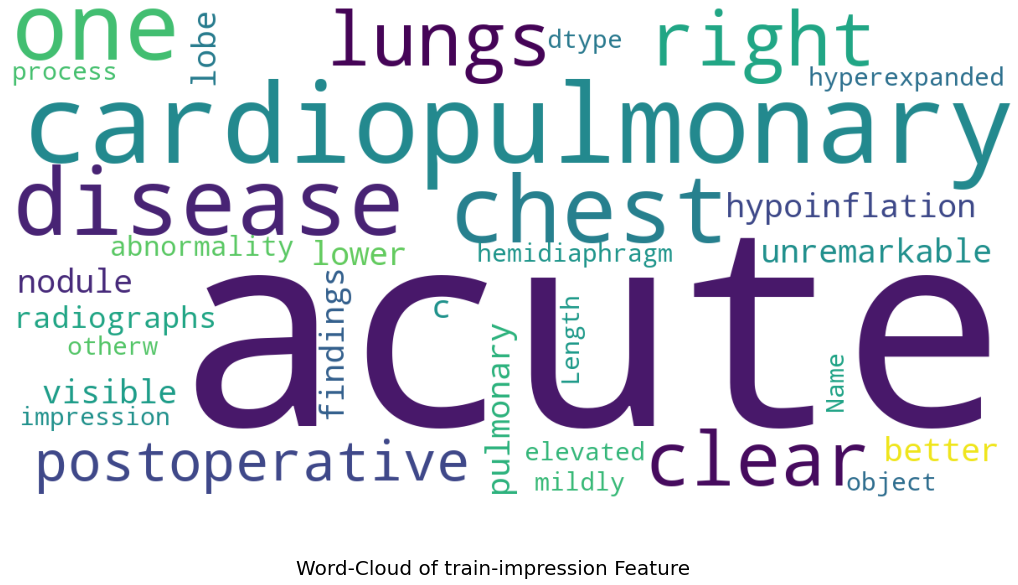

In [273]:
show_wordcloud(train['impression'], title = 'Word-Cloud of train-impression Feature')

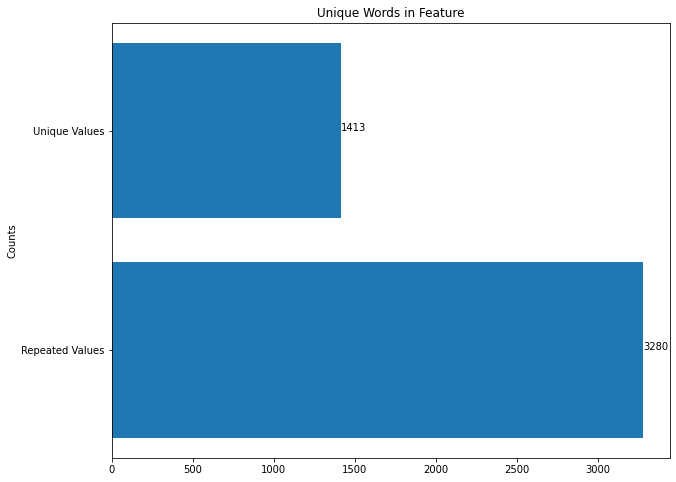

In [274]:
unique_words_features(train.impression)

# Observation Train data :

* We show that wordcloud of train data, some words are acute, lungs, urgent, abnormality, cardiopulmnoary, right impotant words in train data.

* we see that train data have higher number of repeated words than unique words. These unique words usefull for our model vocab.

# Test Data Analysis

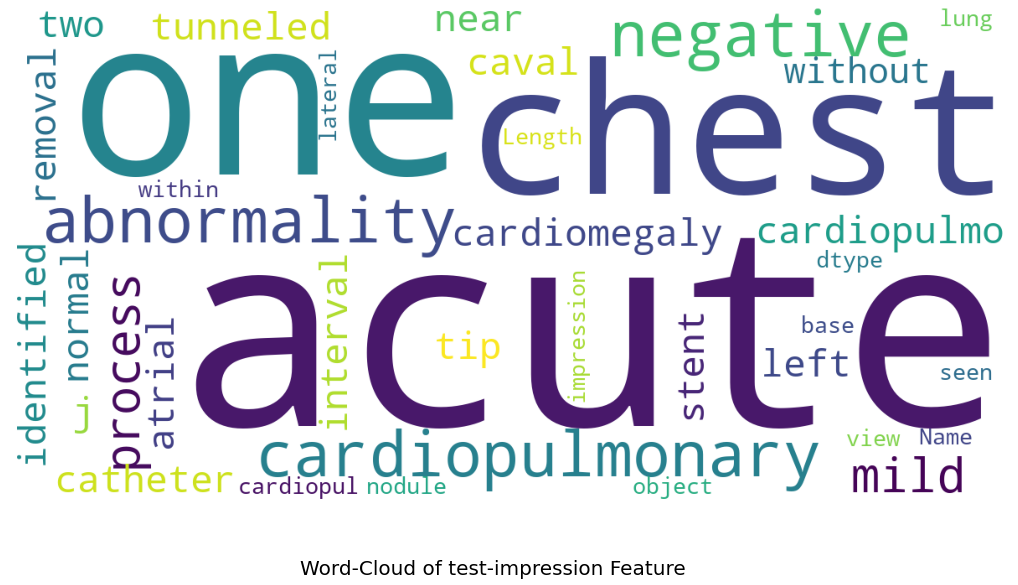

In [275]:
show_wordcloud(test['impression'], title = 'Word-Cloud of test-impression Feature')

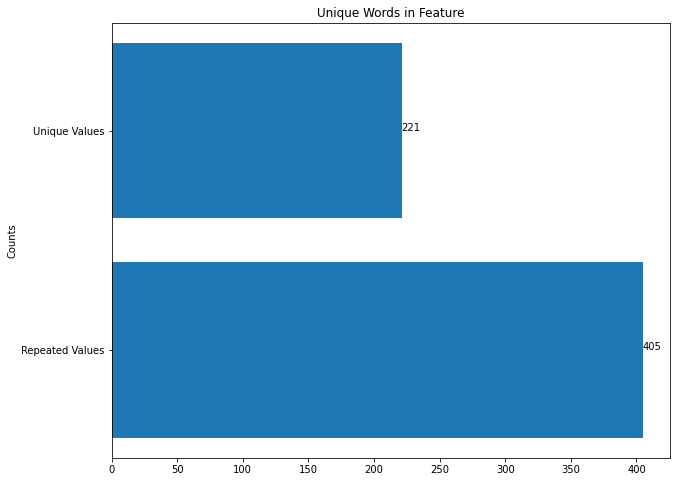

In [276]:
unique_words_features(test.impression)

# Observation Test data :

* We created wordcloud, which words are occurance 1000 times in dataset are important words. acute, findings, disease, abnormality, high, kinds of words.

* Test data contain total 221 unique words and 405 repeated words. We split data into three part train test and validation with 80%, 10% and 10% respectively.

# Validation Data Analysis

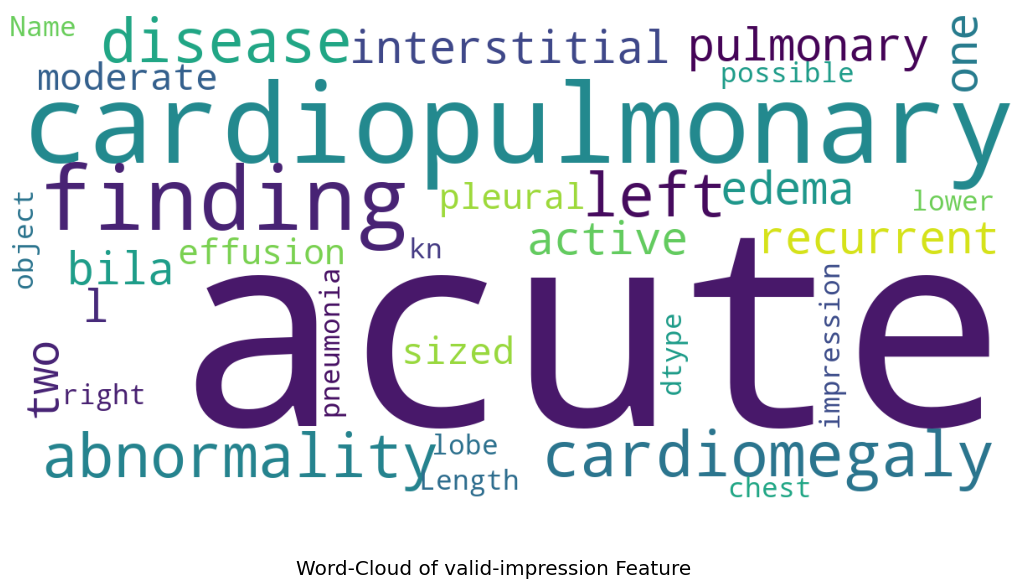

In [277]:
show_wordcloud(valid['impression'], title = 'Word-Cloud of valid-impression Feature')

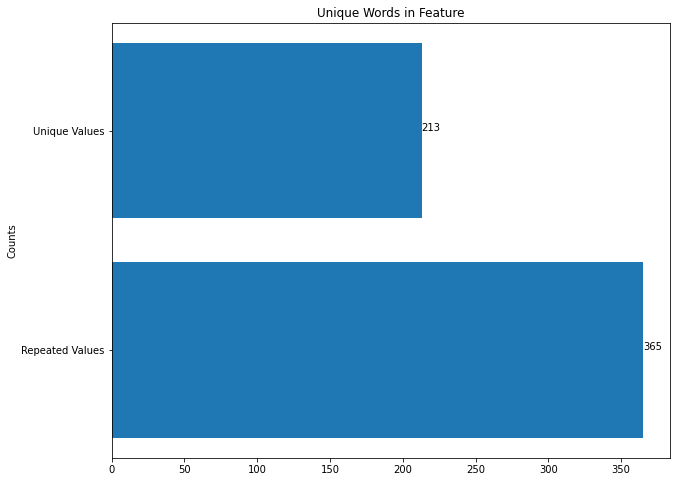

In [278]:
unique_words_features(valid.impression)

# Observation Validation data :

 
 * We created wordcloud, which words are occurance 1000 times in dataset are important words. acute, findings, disease, abnormality, high, right, impression, kinds of words. 
 
 * Some words are frequently present in train, test and validation data like acute, abnormality, disease, right and lungs, these words are most important words in whole datasets.

* Data contain total 213 unique words and 365 repeated words.